22/04/04 01:41:20 WARN Utils: Your hostname, algorand-druid-and-spark resolves to a loopback address: 127.0.0.1; using 172.23.149.212 instead (on interface ens3)
22/04/04 01:41:20 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/04/04 01:41:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


root
 |-- round: long (nullable = true)
 |-- intra: integer (nullable = true)
 |-- typeenum: short (nullable = true)
 |-- asset: long (nullable = true)
 |-- txid: binary (nullable = true)
 |-- txn: string (nullable = true)
 |-- extra: string (nullable = true)



Number of transactions:  33828


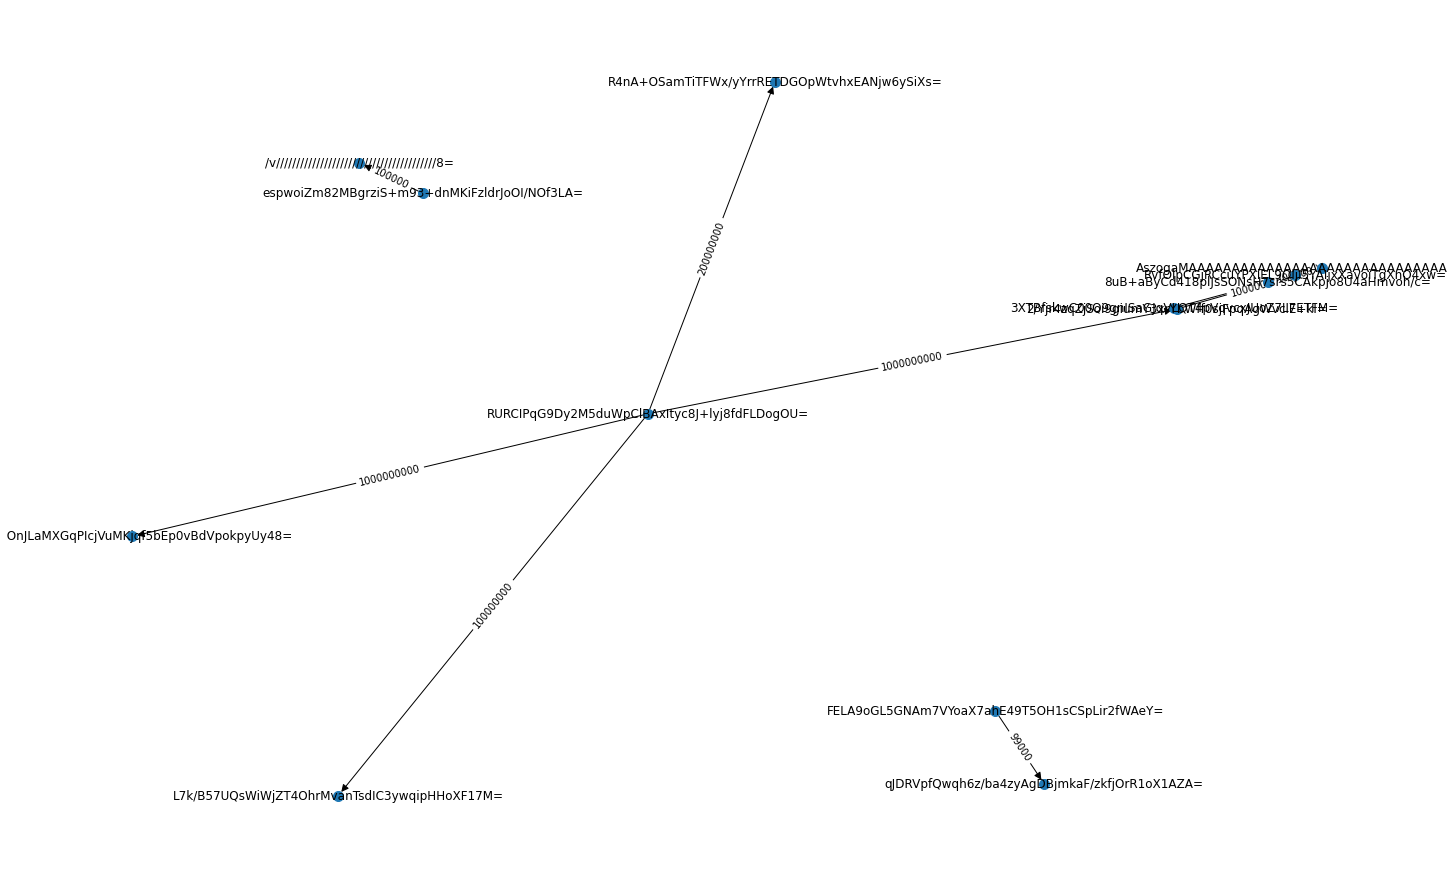

In [1]:
# transactions graph over smaller subset

import pyspark
import json
import networkx as nx
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from datetime import datetime, date
from pyspark.sql import Row

spark = SparkSession \
    .builder \
    .appName("ExampleQueryTransactionsGraph") \
    .master("spark://172.23.149.212:7077") \
    .config("spark.jars", "file:///opt/spark/jars/postgresql-42.3.3.jar") \
    .getOrCreate()

df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.23.149.211:5432/indexer") \
    .option("dbtable", "txn") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .load()

df.printSchema()
dfTransactions = df.select(df["txn"])
dfTransactions = dfTransactions.collect()
print("Number of transactions: ", len(dfTransactions))

    
# create a graph for the first 100 transactions
g = nx.DiGraph()
for i in range(10):
    transaction = json.loads(dfTransactions[i][0])
    try:
        g.add_node(transaction['txn']['rcv'])
        g.add_node(transaction['txn']['snd'])
        g.add_edge(transaction['txn']['snd'], transaction['txn']['rcv'], weight=transaction['txn']['amt'])
    except:
        pass
        

plt.figure(1, figsize=(20, 12))

edgeLabels = nx.get_edge_attributes(g,'weight')
pos = nx.spring_layout(g)
nx.draw(g, with_labels=True, arrowsize=15, node_size=100, pos=pos, font_size=12)
nx.draw_networkx_edge_labels(g, pos, edge_labels=edgeLabels)
plt.show()

spark.stop()

In [2]:
# community detection over all transactions without graph

import pyspark
import json
import networkx as nx
import networkx.algorithms.community as nxcom

from pyspark.sql import SparkSession
from datetime import datetime, date
from pyspark.sql import Row

spark = SparkSession \
    .builder \
    .appName("ExampleQueryClustersInTransactions") \
    .master("spark://172.23.149.212:7077") \
    .config("spark.jars", "file:///opt/spark/jars/postgresql-42.3.3.jar") \
    .getOrCreate()

df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.23.149.211:5432/indexer") \
    .option("dbtable", "txn") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .load()

df.printSchema()
dfTransactions = df.select(df["txn"])
dfTransactions = dfTransactions.collect()
print("Number of transactions: ", len(dfTransactions))

# create graph with all transactions for all communities
g = nx.DiGraph()
for i in range(len(dfTransactions)):
    transaction = json.loads(dfTransactions[i][0])
    try:
        g.add_node(transaction['txn']['rcv'])
        g.add_node(transaction['txn']['snd'])
        g.add_edge(transaction['txn']['snd'], transaction['txn']['rcv'])
    except:
        pass

communities = nxcom.greedy_modularity_communities(g)
print(communities)

spark.stop()

root
 |-- round: long (nullable = true)
 |-- intra: integer (nullable = true)
 |-- typeenum: short (nullable = true)
 |-- asset: long (nullable = true)
 |-- txid: binary (nullable = true)
 |-- txn: string (nullable = true)
 |-- extra: string (nullable = true)



Number of transactions:  33828
[frozenset({'8ESqNMBcv/PQ4h9a4Tgn5211k2hkHLur56HN7v1/R7E=', '6WRrgBD4zzNFcBCnWeePcM7x503i2xTLkkfUYKLGX6M=', '7HWVzrCRH1I15yz64h64JiQb+OHgXxXK5mENXpHHVAE=', '/Lt9hWNGunyk129r2QsvEv837yEIplwEOoFo/kXHixg=', '1AAX9UZsLlCsEn47yAFeiik/GV1biT5ovQScB2CFtZc=', 'HHVDc3oYkb476w6FWDy6RUqoA3l8UMFsaax8vLJ6u1A=', '7zBHA8CEyZjlcGTnB8PN2dAc/whwD71JerDfNjZSu5M=', 'EyHtX0fBIcDdsPIBsmy7Mi/HDbf5HpLPFHgBhqO39/k=', '7UJcVyMvRXpSUNQzAFDk30MxKpcshBz/+AZyHoxPujk=', '2JsZcEoRoqoqA0pYQZEr7rteRCbPIWPzpuZVJsL8hic=', '2qFqY/YaNTMcl3OVQQJOL7+s2L6lwhcedkvgl66Pe/Y=', '+1gXHUhEkJEdmyjOXsviBDpEhms+1BaXagz+kCOdvWA=', '2r0p9Wwt/2hSdnwsQl6UQ3sVPM8ET8h+LRKGgDgaQrU=', 'T81MoYqpV6Ft7yDCreM3xgjoIgeR2VHA++PM6CE+MSY=', '3q0Zyn2SdYerNB11i/ceQCpli10QodaPRbY0xGQTt0A=', 'pqXJHO9/ObhxW5vwX4isBll8peMcC2QWd8LC8rGPx60=', '1m1Yw7eKGbBNyUXvRSXfzHFQKRecYKbS+60M4ES54y8=', '8nG0gmAYPzzgo8oxY5/xvJzQnIwkxVqtZvgOVY/jXuI=', 'zytHPr8bLLTGPxuRVXs4rgmY6N2P1OXcRsox1k+IGXY=', '7+rtn6RKxYwqz3TX3KL7h6QorJxwzxv07AsgWcq7z+s=

root
 |-- round: long (nullable = true)
 |-- intra: integer (nullable = true)
 |-- typeenum: short (nullable = true)
 |-- asset: long (nullable = true)
 |-- txid: binary (nullable = true)
 |-- txn: string (nullable = true)
 |-- extra: string (nullable = true)



Number of transactions:  33828


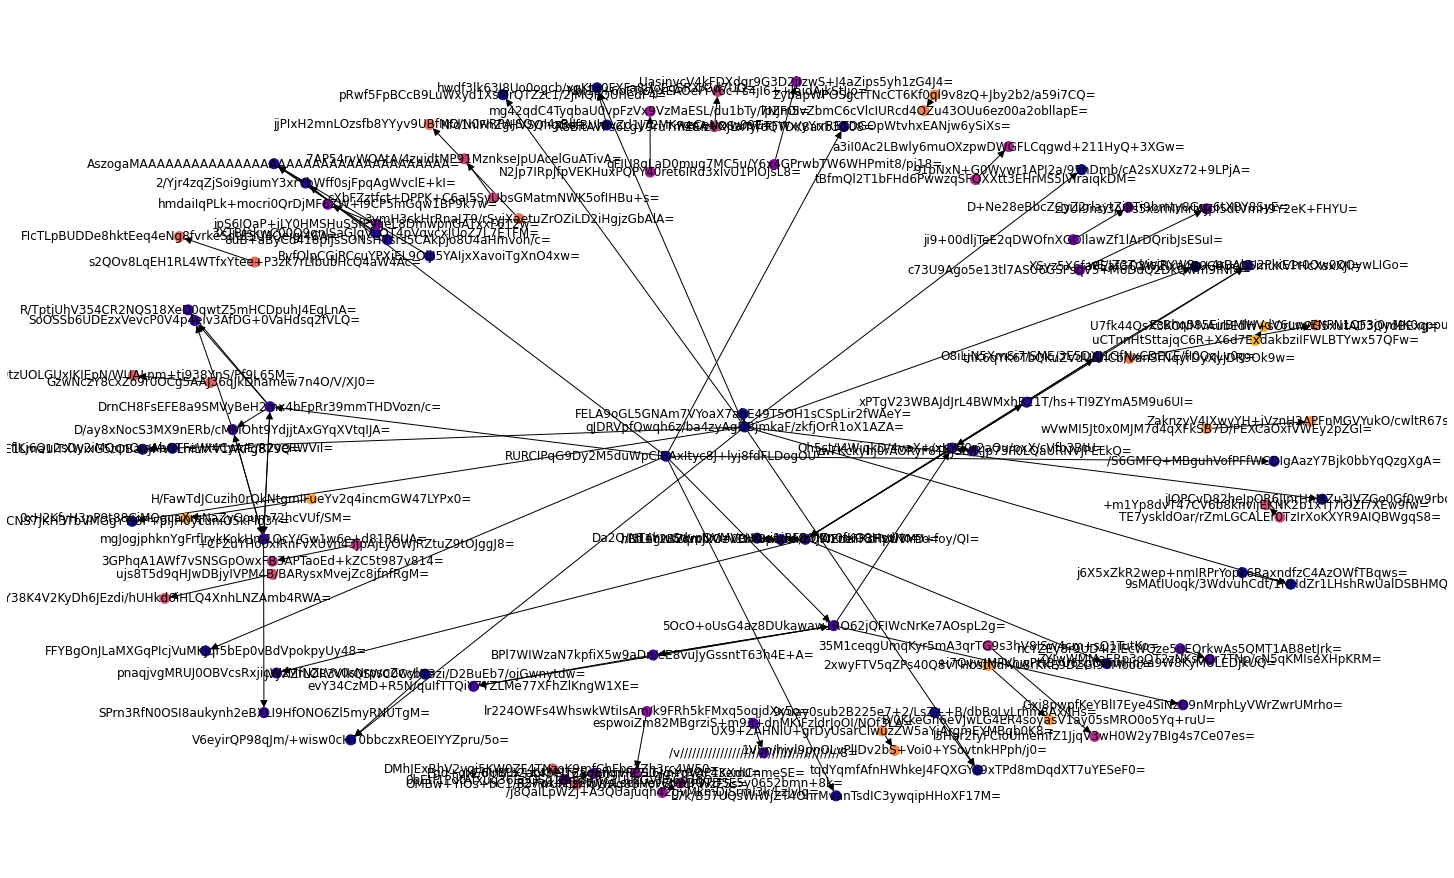

In [3]:
# community detection with graph over smaller subset

import pyspark
import json
import networkx as nx
import networkx.algorithms.community as nxcom
import matplotlib.pyplot as plt
import matplotlib as mpt

from pyspark.sql import SparkSession
from datetime import datetime, date
from pyspark.sql import Row

spark = SparkSession \
    .builder \
    .appName("ExampleQueryClustersInTransactions") \
    .master("spark://172.23.149.212:7077") \
    .config("spark.jars", "file:///opt/spark/jars/postgresql-42.3.3.jar") \
    .getOrCreate()

df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.23.149.211:5432/indexer") \
    .option("dbtable", "txn") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .load()

df.printSchema()
dfTransactions = df.select(df["txn"])
dfTransactions = dfTransactions.collect()
print("Number of transactions: ", len(dfTransactions))

g = nx.DiGraph()
for i in range(100):
    transaction = json.loads(dfTransactions[i][0])
    try:
        g.add_node(transaction['txn']['rcv'])
        g.add_node(transaction['txn']['snd'])
        g.add_edge(transaction['txn']['snd'], transaction['txn']['rcv'])
    except:
        pass
    
colors = [mpt.colors.rgb2hex(c) for c in plt.get_cmap(name='plasma', lut=40).colors]
communities = nxcom.greedy_modularity_communities(g)

for community_index in range(0, len(communities)):
    for node in communities[community_index]:
          g.nodes[node]['color'] = colors[community_index]

plt.figure(1, figsize=(20, 12))
pos = nx.spring_layout(g)
nx.draw(g, with_labels=True, arrowsize=15, node_size=100, pos=pos, font_size=12, node_color = [g.nodes[v]['color'] for v in g.nodes()])
plt.show()

spark.stop()

In [4]:
#get all senders with a transaction amount over searchedValue Algos

from pyspark.sql import SparkSession
from datetime import datetime, date
from pyspark.sql import Row
import json

spark = SparkSession \
    .builder \
    .appName("ExampleQueryTransactionsGraph") \
    .master("spark://172.23.149.212:7077") \
    .config("spark.jars", "file:///opt/spark/jars/postgresql-42.3.3.jar") \
    .getOrCreate()

df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.23.149.211:5432/indexer") \
    .option("dbtable", "txn") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .load()

df.printSchema()
# df.select(df["txn"]).show()
dfTransactions = df.select(df["txn"])
dfTransactions = dfTransactions.collect()
searchedValue = 10000000    
print(len(dfTransactions))
resDictionary = {}
#print((dfTransactions[0][0]))

for i in range(len(dfTransactions)):
    transaction = json.loads(dfTransactions[i][0])
    try: 
        if (transaction["txn"]["amt"]/1000000) >= searchedValue:
        #/1000000 because amt is in micro algos
            resDictionary[transaction["txn"]["snd"]] = (transaction["txn"]["amt"]/1000000)
    except:
        pass
print(resDictionary)

spark.stop()

root
 |-- round: long (nullable = true)
 |-- intra: integer (nullable = true)
 |-- typeenum: short (nullable = true)
 |-- asset: long (nullable = true)
 |-- txid: binary (nullable = true)
 |-- txn: string (nullable = true)
 |-- extra: string (nullable = true)



33828
{'espwoiZm82MBgrziS+m93+dnMKiFzldrJoOI/NOf3LA=': 100000000.0, 'RURCIPqG9Dy2M5duWpClBAxItyc8J+lyj8fdFLDogOU=': 12250000.0, 'cZ/lK6oTDz4ZxIXTxa2p+Pz/IP9le2z0l+ZsAR3/6gc=': 10000000.0}


In [5]:
#highest total rewards in Algo a miner has gotten with the according miner address

from pyspark.sql import SparkSession
from datetime import datetime, date
from pyspark.sql import Row
import json
import binascii

spark = SparkSession \
    .builder \
    .appName("ExampleQueryTransactionsGraph") \
    .master("spark://172.23.149.212:7077") \
    .config("spark.jars", "file:///opt/spark/jars/postgresql-42.3.3.jar") \
    .getOrCreate()

df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.23.149.211:5432/indexer") \
    .option("dbtable", "account") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .load()

#store rewards in a list format
dfRewards = df.select(df["rewards_total"])
dfRewards = dfRewards.collect()

#Copy all rewards to a list
allVal = []
for row in dfRewards:
    allVal.append(row['rewards_total'])

#store address of miner with the largest total_rewards in dict
addr = df.where(df["rewards_total"] == max(allVal)).select(df["addr"]).collect()
dataDict = {}
for row in addr:
    dataDict[binascii.hexlify(bytearray(row['addr']))] = max(allVal)/1000000
    
#print largest value a miner got in Algo    
print(max(allVal)/1000000)
#print address and largest value a miner got
print(dataDict)

spark.stop()

257606.167317
{b'67eea98617ac0115cbe8acbcda8ced5a4a805e3a118d99d064545078d5765f66': 257606.167317}


In [ ]:
#find transaction with highest value, return sender receiver and amound

from pyspark.sql import SparkSession
from datetime import datetime, date
from pyspark.sql import Row
import json

spark = SparkSession \
    .builder \
    .appName("ExampleQueryTransactionsGraph") \
    .master("spark://172.23.149.212:7077") \
    .config("spark.jars", "file:///opt/spark/jars/postgresql-42.3.3.jar") \
    .getOrCreate()

df = spark.read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.23.149.211:5432/indexer") \
    .option("dbtable", "txn") \
    .option("user", "postgres") \
    .option("password", "postgres") \
    .option("driver", "org.postgresql.Driver") \
    .load()

dfTransactions = df.select(df["txn"])
dfTransactions = dfTransactions.collect()   


highestValue = 0


for i in range(len(dfTransactions)):
    transaction = json.loads(dfTransactions[i][0])
    try: 
        if (transaction["txn"]["amt"]) >= highestValue:
        #/1000000 because amt is in micro algos
            highestValue = transaction["txn"]["amt"]
            sender = transaction["txn"]["snd"]
            receiver = transaction["txn"]["rcv"]
    except:
        pass


print("highest transaction: ")
print("from: " + str(sender) + "\nto: " + str(receiver) +"\namount in Algos: "+ str(highestValue/1000000))

spark.stop()

highest transaction: 
from: espwoiZm82MBgrziS+m93+dnMKiFzldrJoOI/NOf3LA=
to: zSPw7RCKnQg2i/53M79EZNda67oSf+Jjm1947/Im/Ho=
amount in Algos: 100000000.0
